# Covariance v Coherence

In [1]:
import os
import sys

# import h5py
# from IPython.display import HTML, display
import numpy as np

# from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# from scipy.fft import ifft
# import scipy.signal as ss
# import scipy.linalg as sl
# from sklearn.utils.extmath import randomized_svd
import time

# sys.path.append('../')
sys.path.append(os.path.join(os.path.dirname(""), os.pardir))
import coherence_analysis.utils as f

In [21]:
fsize = 15

samples_per_sec = 1000
subwindow_len = 1
overlap = 0

start_ch = 3100
nchannels = 2000
nsensors = 200

In [3]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data, _ = f.load_brady_hdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2, _ = f.load_brady_hdf5(file, normalize="no")

data = np.append(data, data2, axis=1)
# data = np.append(data3,data,axis=1)

In [22]:
t0 = time.time()
coherence_big_event, frequencies = f.welch_coherence(
    data[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    subwindow_len,
    overlap,
    sample_interval=0.001,
)
t1 = time.time()
coherence_time = t1 - t0

t0 = time.time()
preprocessed_data = f.covariance_preprocessing(data[start_ch : nchannels + start_ch : int(nchannels / nsensors)], sample_interval=1/samples_per_sec)
covariance, frequencies = f.covariance(
    preprocessed_data,
    subwindow_len,
    overlap,
    sample_interval=0.001,
)
t1 = time.time()
covariance_time = t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 13.083431720733643
Covariance time: 12.589540243148804


In [23]:
num_frames = coherence_big_event.shape[0]
eig_ratios_coherence = np.empty(num_frames)
eig_ratios_covariance = np.empty(num_frames)

t0 = time.time()
for d in range(num_frames):
    # eigenvals, _ = np.linalg.eig(coherence_big_event[d])
    eigenvals = np.linalg.eigvalsh(coherence_big_event[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios_coherence[d] = eigenvals[0] / np.sum(eigenvals)
t1 = time.time()
coherence_time += t1 - t0

t0 = time.time()
for d in range(num_frames):
    # eigenvals, _ = np.linalg.eig(covariance[d])
    eigenvals = np.linalg.eigvalsh(covariance[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios_covariance[d] = eigenvals[0] / np.sum(eigenvals)
t1 = time.time()
covariance_time += t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 14.575808763504028
Covariance time: 20.48969578742981


(array([7.559184e+06, 4.051726e+06, 2.416360e+06, 1.532066e+06,
        9.908300e+05, 6.709940e+05, 4.654000e+05, 3.371500e+05,
        2.548760e+05, 2.018600e+05, 1.660580e+05, 1.273920e+05,
        1.040860e+05, 9.143000e+04, 7.743200e+04, 6.717200e+04,
        5.925600e+04, 5.160400e+04, 4.732800e+04, 4.119200e+04,
        3.570600e+04, 3.299000e+04, 2.935000e+04, 2.688800e+04,
        2.649600e+04, 2.442600e+04, 2.314400e+04, 2.125800e+04,
        1.887600e+04, 1.722400e+04, 1.684200e+04, 1.592400e+04,
        1.516200e+04, 1.468000e+04, 1.398200e+04, 1.349800e+04,
        1.254600e+04, 1.209400e+04, 1.179200e+04, 1.083800e+04,
        1.064800e+04, 1.006000e+04, 9.540000e+03, 9.236000e+03,
        8.926000e+03, 8.372000e+03, 8.114000e+03, 8.076000e+03,
        7.386000e+03, 7.122000e+03, 6.716000e+03, 6.422000e+03,
        6.198000e+03, 5.866000e+03, 5.508000e+03, 5.388000e+03,
        5.208000e+03, 4.854000e+03, 4.858000e+03, 4.394000e+03,
        4.198000e+03, 3.998000e+03, 3.88

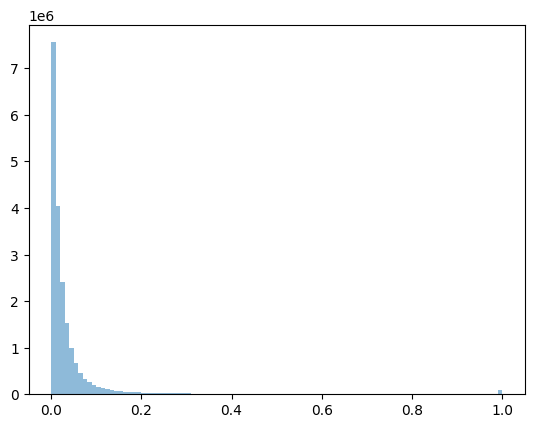

In [25]:
# plt.hist(covariance.flatten(), bins=100, alpha=0.5, label="Covariance")
plt.hist(coherence_big_event.flatten(), bins=100, alpha=0.5, label="Coherence")

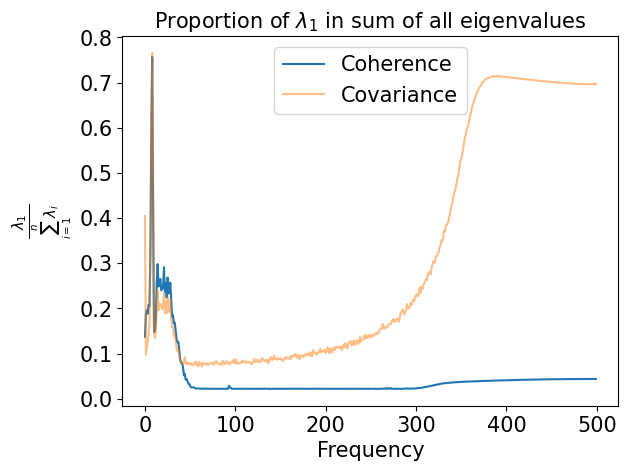

In [24]:
frequency_extent_ind = -1
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_coherence[:frequency_extent_ind],
    label="Coherence",
)
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_covariance[:frequency_extent_ind],
    label="Covariance",
    alpha=0.5,
)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title(
    "Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)
plt.legend(fontsize=fsize)

In [42]:
t0 = time.time()
norm_win_spectra, frequencies = f.normalised_windowed_spectra(
    data[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    subwindow_len,
    overlap,
    sample_interval=0.001,
)
t1 = time.time()
coherence_time = t1 - t0

t0 = time.time()
preprocessed_data = f.covariance_preprocessing(data[start_ch : nchannels + start_ch : int(nchannels / nsensors)], sample_interval=1/samples_per_sec)
win_spectra, frequencies = f.windowed_spectra(
    preprocessed_data,
    subwindow_len,
    overlap,
    freq=None,
    sample_interval=0.001,
)
win_spectra = win_spectra.transpose(2, 1, 0)
t1 = time.time()
covariance_time = t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 1.3443500995635986
Covariance time: 2.375965118408203


In [30]:
num_frames = coherence_big_event.shape[0]
eig_ratios_coherence = np.empty(num_frames)
eig_ratios_covariance = np.empty(num_frames)

t0 = time.time()
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(norm_win_spectra[d])
    S = np.linalg.svd(
            norm_win_spectra[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_coherence[d] = np.max(svd_approx) / np.sum(svd_approx)
t1 = time.time()
coherence_time += t1 - t0

t0 = time.time()
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra[d])
    S = np.linalg.svd(
            win_spectra[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_covariance[d] = np.max(svd_approx2) / np.sum(svd_approx2)
t1 = time.time()
covariance_time += t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 6.068689346313477
Covariance time: 5.630174398422241


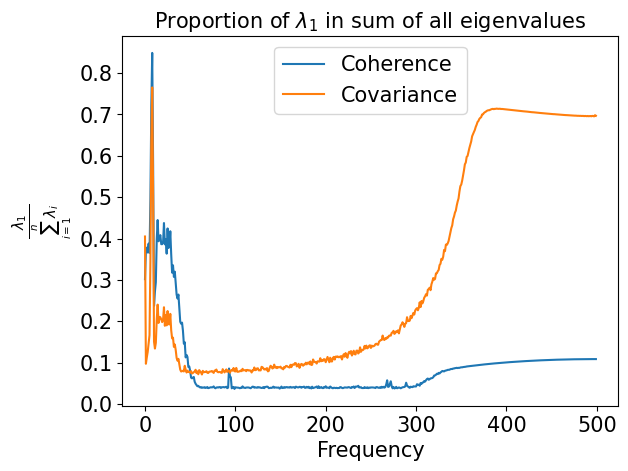

In [31]:
frequency_extent_ind = -1
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_coherence[:frequency_extent_ind],
    label="Coherence",
)
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_covariance[:frequency_extent_ind],
    label="Covariance",
)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title(
    r"Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)
plt.legend(fontsize=fsize)

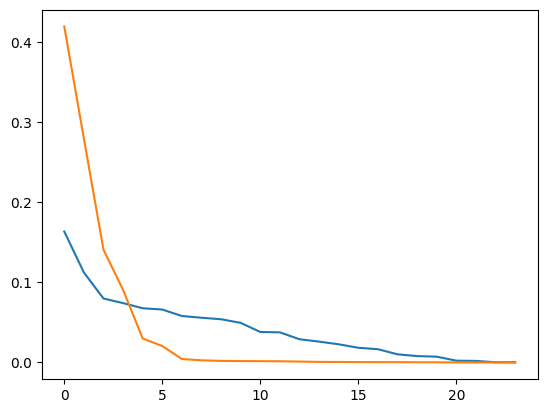

In [16]:
plt.plot(svd_approx / np.sum(svd_approx))
plt.plot(svd_approx2 / np.sum(svd_approx2))

In [33]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data_noise, _ = f.load_brady_hdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data_noise2, _ = f.load_brady_hdf5(file, normalize="no")

data_noise = np.append(data_noise, data_noise2, axis=1)

In [38]:
t0 = time.time()
norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(
    data_noise[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    subwindow_len,
    overlap,
    sample_interval=0.001,
)
t1 = time.time()
coherence_time = t1 - t0

t0 = time.time()
preprocessed_data_noise = f.covariance_preprocessing(data_noise[start_ch : nchannels + start_ch : int(nchannels / nsensors)], sample_interval=1/samples_per_sec)
win_spectra_noise, frequencies = f.windowed_spectra(
    preprocessed_data_noise,
    subwindow_len,
    overlap,
    freq=None,
    sample_interval=0.001,
)
win_spectra_noise = win_spectra_noise.transpose(2, 1, 0)
t1 = time.time()
covariance_time = t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 1.6366558074951172
Covariance time: 2.890547513961792


In [39]:
num_frames = win_spectra_noise.shape[0]
eig_ratios_coherence_noise = np.empty(num_frames)
eig_ratios_covariance_noise = np.empty(num_frames)

t0 = time.time()
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(norm_win_spectra_noise[d])
    S = np.linalg.svd(
            norm_win_spectra_noise[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_coherence_noise[d] = np.max(svd_approx2) / np.sum(svd_approx2)
t1 = time.time()
coherence_time += t1 - t0

t0 = time.time()
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
    S = np.linalg.svd(
            win_spectra_noise[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_covariance_noise[d] = np.max(svd_approx2) / np.sum(svd_approx2)
t1 = time.time()
covariance_time += t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 6.019936800003052
Covariance time: 7.255411863327026


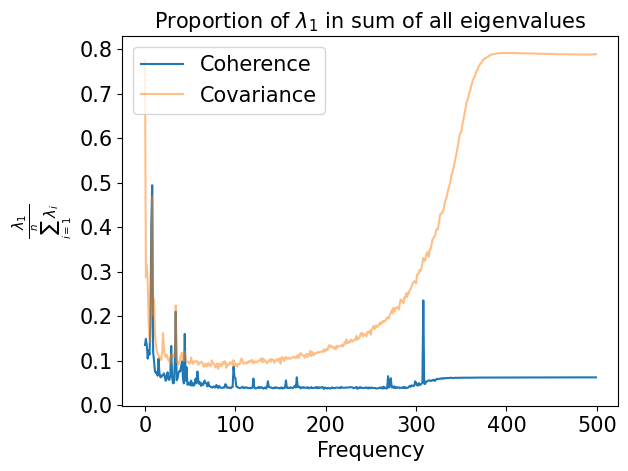

In [41]:
frequency_extent_ind = -1
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_coherence_noise[:frequency_extent_ind],
    label="Coherence",
)
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_covariance_noise[:frequency_extent_ind],
    label="Covariance",
    alpha=0.5,
)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title(
    "Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)
plt.legend(fontsize=fsize)